In [1]:
import pylas # to read in the point cloud
import pdal
import geopandas as gpd
import json
import numpy as np
import os

from shapely.geometry import Polygon, MultiPolygon

from scipy.spatial import Delaunay
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize

import warnings

In [2]:
str_convex_hull_ar = r'D:\concave_hull_test_20230220\input_convex_hull\convex_hull_dfw_3857_ar.shp'
str_copc_point_cloud = r'D:\concave_hull_test_20230220\merge_bridge_copc\bridge_merge_pecos_dallas.copc.laz'
str_output_las_dir = r'D:\concave_hull_test_20230220'

In [3]:
def fn_get_concave_alpha_boundary(str_las_cluster_filepath, flt_alpha_value):
    
    # args:
    #  str_las_cluster_filepath = las filepath of the idetified point cloud cluster
    #           --- example: D:\concave_hull_test_20230220\bridge_3047.las
    #  flt_alpha_value = alpha value to process
    #          --- example: 0.001 ~ convex hull
    #          --- example: 0.9 ~ highly concave hull
    
    import warnings
    # turn off warnings
    warnings.filterwarnings('ignore')
    
    # read the las file
    las = pylas.read(str_las_cluster_filepath)
    
    # create numpy array from las x,y points
    arr_las_points = np.stack((las.x, las.y), axis=1)
    
    coords = arr_las_points
    #coords = np.array([point.coords[0] for point in points])

    tri = Delaunay(arr_las_points)
    triangles = arr_las_points[tri.vertices]
    
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / flt_alpha_value)]
    
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    
    return cascaded_union(triangles)

In [4]:
def fn_remove_holes_from_polygon(shp_polygon,
                                 flt_min_interior_hole_size_tokeep):
    
    from shapely.geometry import Polygon
    
    list_interiors = []

    for interior in shp_polygon.interiors:
        p = Polygon(interior)    
        if p.area > flt_min_interior_hole_size_tokeep:
            list_interiors.append(interior)

    new_polygon = Polygon(shp_polygon.exterior.coords, holes=list_interiors)
    
    return new_polygon

In [5]:
def fn_remove_holes_from_multipolygon(shp_multipolygon,
                                      flt_min_interior_hole_size_tokeep):
    
    from shapely.geometry import Polygon, MultiPolygon
    
    list_parts = []
    
    for polygon in shp_multipolygon.geoms:
        list_interiors = []
        
        for interior in polygon.interiors:
            p = Polygon(interior)

            if p.area > flt_min_interior_hole_size_tokeep:
                list_interiors.append(interior)
                
        temp_pol = Polygon(polygon.exterior.coords, holes=list_interiors)
        list_parts.append(temp_pol)
        
    new_multipolygon = MultiPolygon(list_parts)
    
    return(new_multipolygon)

In [6]:
def fn_get_largest_polygon(shp_hull_polygon):
    
    flt_max_hole_to_keep = 100
    flt_min_island_to_keep = 100
    
    # determine the type of shp_hull_polygon
    if shp_hull_polygon.geom_type == 'MultiPolygon':
        
        # remove the hole from the multipolygon
        shp_multi_no_holes = fn_remove_holes_from_multipolygon(shp_hull_polygon,flt_max_hole_to_keep)
        
        # remove small islands from multipolygon
        shp_island_remove = MultiPolygon([P for P in shp_multi_no_holes if P.area > flt_min_island_to_keep])
        
        shp_largest_polygon = max(shp_hull_polygon, key=lambda a: a.area)
        
    elif shp_polygon_01.geom_type == 'Polygon':
        shp_largest_polygon = shp_hull_polygon
        
    return shp_largest_polygon

In [211]:
%%time

#def fn_determine_concave_hull(gdf_single_convex_hull, 
#                              str_copc_point_cloud,
#                              str_output_las_dir)
                              

int_bridge_index = 2588

# read the "area of interest" shapefile in to geopandas dataframe
gdf_convex_hulls = gpd.read_file(str_convex_hull_ar)

# get all the points inside the id = 2004 polygon
gdf_single_convex = gdf_convex_hulls.loc[gdf_convex_hulls['id'] == int_bridge_index]

# convex hull as wkt
str_boundary_wkt = gdf_single_convex.iloc[0].geometry.wkt

# point cloud per convex hull as las
str_output_las = os.path.join(str_output_las_dir, "bridge_" + str(int_bridge_index) + '.las')

pipeline_create_copc = {
    "pipeline": [
        {   
            "filename":str_copc_point_cloud,
            "type":"readers.copc",
            "tag":"readdata"
        },
        {
            "type":"filters.crop",
            "polygon":str_boundary_wkt,
            "tag":"filter"
        },
        {
            "filename": str_output_las,
            "inputs": [ "filter" ],
            "type": "writers.las"
        }
    ]}

if os.path.exists(str_output_las):
    print('All ready exists')
else:
    #execute the pdal pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_create_copc))
    n_points = pipeline.execute()

# read the las file
las = pylas.read(str_output_las)
print('Points found: ' + str(len(las.x)))

flt_desired_target = 0.25

# default to concave hull
shp_poly_to_process = fn_get_concave_alpha_boundary(str_output_las, 0.0001)

# compute the first alpha shape
shp_polygon_01 = fn_get_concave_alpha_boundary(str_output_las, 0.1)

if (shp_polygon_01.area / len(las.x)) > flt_desired_target:
    shp_poly_to_process = shp_polygon_01
    shp_polygon_02 = fn_get_concave_alpha_boundary(str_output_las, 0.2)
    
    if (shp_polygon_02.area / len(las.x)) > flt_desired_target:
        shp_poly_to_process = shp_polygon_02
        shp_polygon_03 = fn_get_concave_alpha_boundary(str_output_las, 0.3)
    
        if (shp_polygon_03.area / len(las.x)) > flt_desired_target:
            shp_poly_to_process = shp_polygon_03

# find the largest polygon
shp_largest = fn_get_largest_polygon(shp_poly_to_process)

# remove the islands from the largest polygon
shp_largest_no_holes = fn_remove_holes_from_polygon(shp_largest, 100)

# simplify the polygon (0.9 meter resolution)
shp_largest_no_holes_simple = shp_largest_no_holes.simplify(0.9, preserve_topology=False)

# determine fraction of points that are inside the polygon
pipeline_points_in_poly = {
    "pipeline": [
        {   
            "filename":str_output_las,
            "type":"readers.las",
            "tag":"readdata"
        },
        {
            "type":"filters.crop",
            "polygon":shp_largest_no_holes.wkt,
            "tag":"filter"
        }
    ]}

#execute the pdal pipeline
pipeline = pdal.Pipeline(json.dumps(pipeline_points_in_poly))
n_points = pipeline.execute()
print('Points in concav hull polygon: ' + str(n_points))

flt_fraction_point_in_poly = n_points/len(las.x)
print('Percent points in polygon: ' + str(flt_fraction_point_in_poly))

# return gdf_concave_hull_poly

Points found: 24287
Points in concav hull polygon: 24254
Percent points in polygon: 0.9986412484044962
CPU times: total: 1min 12s
Wall time: 42.6 s


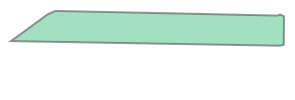

In [212]:
shp_largest_no_holes_simple

In [213]:
shp_largest_no_holes_simple.wkt

'POLYGON ((-10807852.31 3861665.4, -10807823.42 3861686.56, -10807815.51 3861689.94, -10807593.46 3861685.3000000003, -10807590.88 3861686.34, -10807586.93 3861684.52, -10807587.26 3861656.0100000002, -10807591.35 3861655.15, -10807860.1 3861659.75, -10807852.31 3861665.4))'

In [214]:
def fn_polygons_in_shape(shp_poly_to_process):
    # determine the type of shp_hull_polygon
    if shp_poly_to_process.geom_type == 'MultiPolygon':
        int_count_polygons = len(list(shp_poly_to_process))
    else:
        int_count_polygons = 1
    return int_count_polygons

In [215]:
# default to concave hull
shp_poly_to_process = fn_get_concave_alpha_boundary(str_output_las, 0.0001)

# start with a value of 0.10
flt_delta_increase = 0.07

flt_try_value = 0.08
shp_boundary_to_check = fn_get_concave_alpha_boundary(str_output_las, flt_try_value)

flt_polygons_created = fn_polygons_in_shape(shp_boundary_to_check)

if flt_polygons_created > 1:
    while flt_polygons_created > 1:
        flt_try_value = flt_try_value / 2
        shp_boundary_to_check = fn_get_concave_alpha_boundary(str_output_las, flt_try_value)
        flt_polygons_created = fn_polygons_in_shape(shp_boundary_to_check)
        print(flt_try_value)
else:
    # the first pass yielded a single polygon
    # increase by value until it breaks
    #while flt_polygons_created == 1:
    
    while flt_try_value <= 0.75:
        flt_try_value += flt_delta_increase
        shp_boundary_to_check = fn_get_concave_alpha_boundary(str_output_las, flt_try_value)
        flt_polygons_created = fn_polygons_in_shape(shp_boundary_to_check)
        print(flt_try_value)
        
        if flt_polygons_created > 0:
            break
        
    flt_try_value -= flt_delta_increase
    shp_boundary_to_check = fn_get_concave_alpha_boundary(str_output_las, flt_try_value)
    
# simplify the polygon (0.9 meter resolution)
shp_simple = shp_boundary_to_check.simplify(0.9, preserve_topology=False)

0.15000000000000002


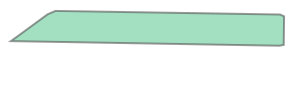

In [216]:
shp_simple

In [217]:
shp_simple.wkt

'POLYGON ((-10807852.31 3861665.4, -10807823.42 3861686.56, -10807815.51 3861689.94, -10807590.88 3861686.34, -10807586.93 3861684.52, -10807587.26 3861656.0100000002, -10807591.35 3861655.15, -10807860.1 3861659.75, -10807852.31 3861665.4))'